<a href="https://colab.research.google.com/github/ananyaaa-j/QCES/blob/main/Copy_of_Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [ ]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [ ]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [ ]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [ ]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [ ]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.12 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

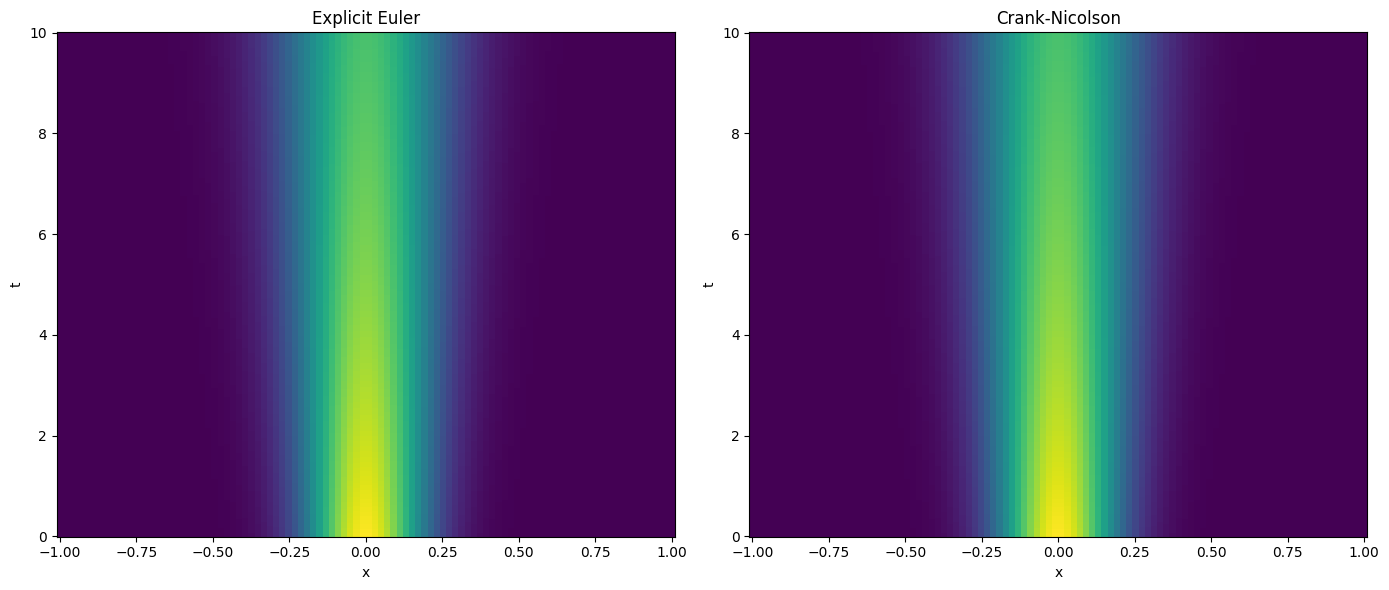

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and/or increase the diffusivity ($\kappa$) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.03 seconds


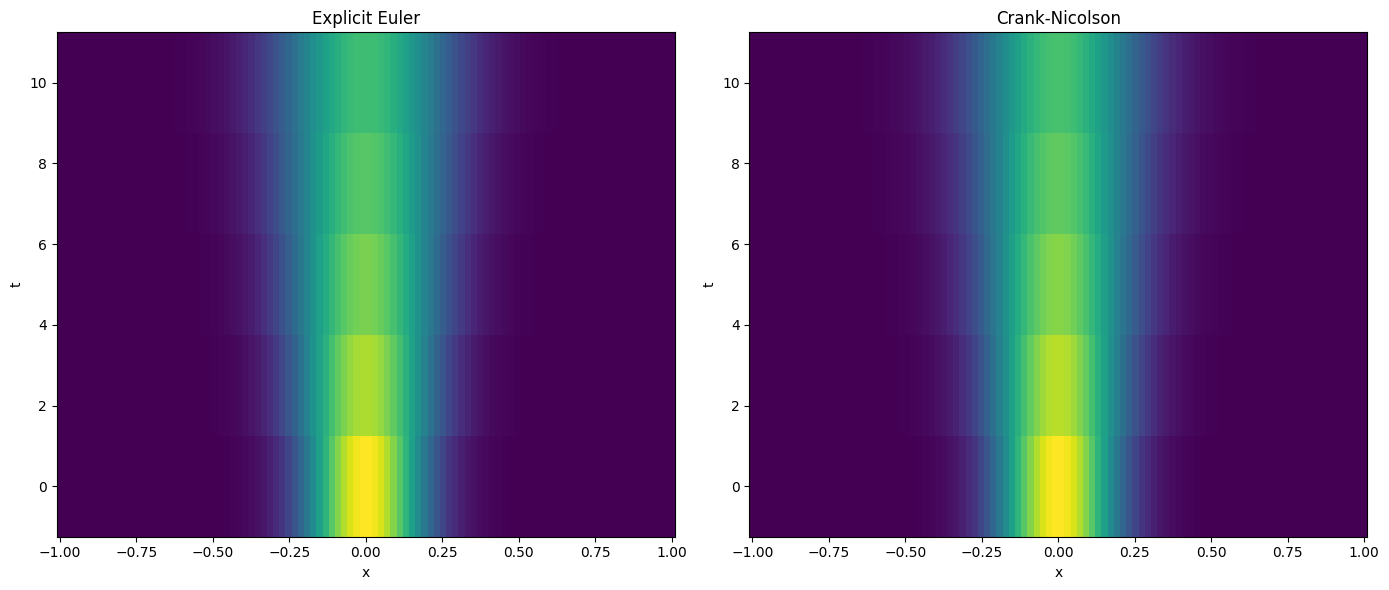

In [ ]:
# Timestepping parameters
Nt = 5  # number of timesteps

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times

# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.05 seconds


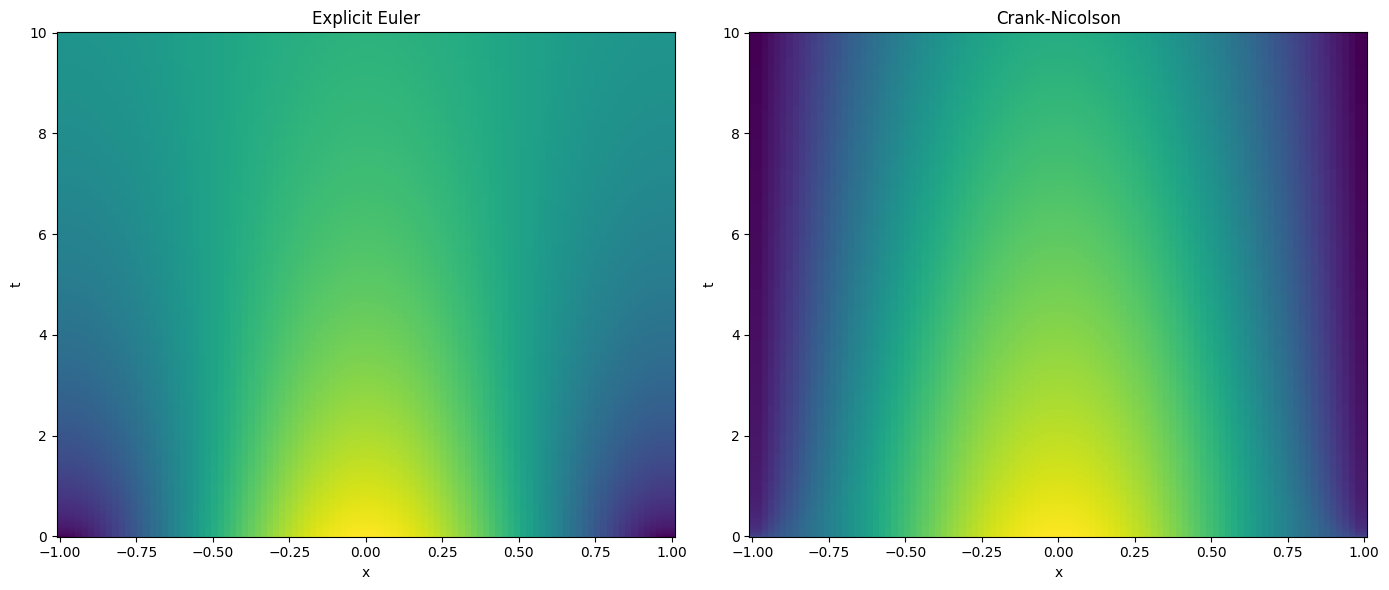

In [ ]:
# Timestepping parameters
Nt = 1000  # number of timesteps
t = np.linspace(t_start, t_end, Nt)  # Create a vector of times

# Run the simulations
c_EE = EE(x, t, 20*kappa) # explicit Euler
c_CN = CN(x, t, 20*kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

INSERT COMMENTS HERE

and see how each method responds. How does the stability depend on Nx?

Increasing the timestep (reduce the number of timesteps):   Discuss your findings below (~1 paragraph)
Decreasing Nt in order to increase the timestep does not effect runtime/cause any issues with the functions, and the methods yields very similar looking results.

Increase the diffusivity ( κ ):
Increasing kappa by a factor of 10 yielded two obviously different concentrationi profiles with the Exact Euler method simulating more diffusivity after ~ 2 seconds.
Increasing kappa by a factor of 20 yielded more difference in results. For the Crank Nicolson method the concentration appeared to be increasing down the concentartion this was however likely due to the non-rigorous nature of the boundary conditions imposed by this method.

Stability = does the code run/break down?

Increasing kappa by factor 50 or more caused the Euler method to break down. For all values tested the Crank Nicolson method did not break down / was stable.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

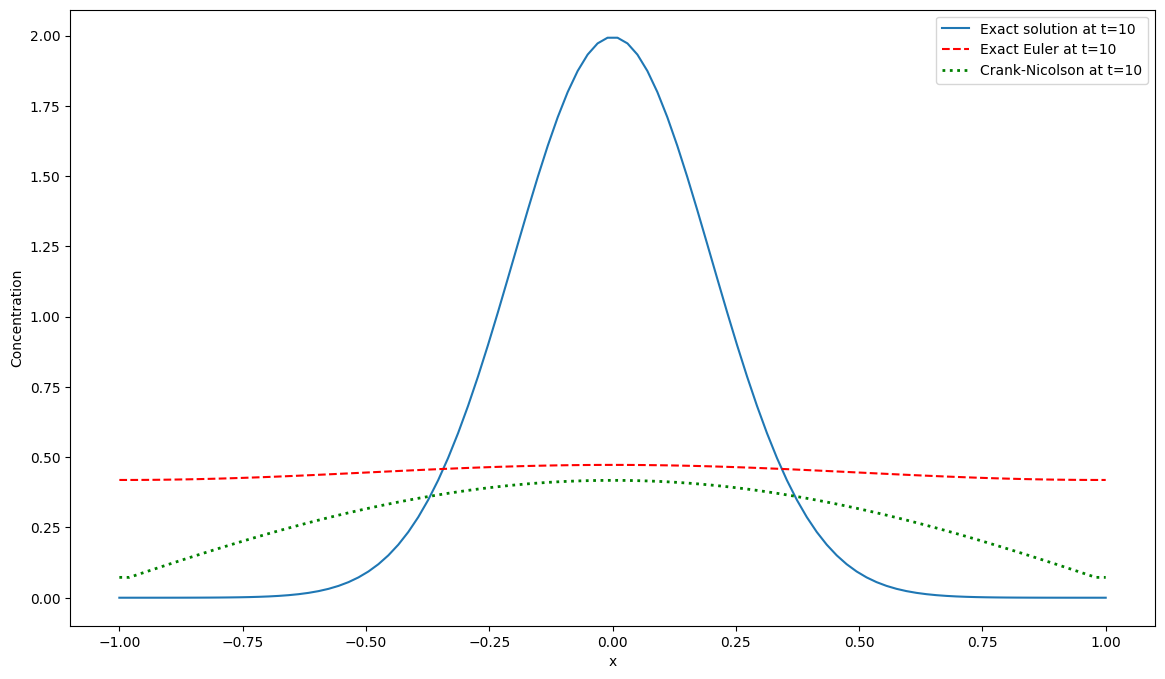

In [ ]:
# Add code to plot exact and numerical solutions

# run code for original parameters again before this shunk
# C_EE and C_CN are 2D arrays and the last column contains values for t=10

# x in a linspace array of values
# for exact method it is undefined at t = 0
# an initial condition is used to start off the numerical methods we set the initial condition using exact solution at t = 10
# so to compare set t = 10 for numerical methods and t = 20 for exact solution
exact_t10 = (4*np.pi*kappa*20)**(-0.5)*np.exp(-x**2 / (4*kappa*20))
# or exact_t10_func = set_ics(x, kappa, 20)

plt.figure(figsize=(14, 8))
plt.plot(x, exact_t10, label = "Exact solution at t=10")
plt.plot(x, exact_t10_func, label = "Exact solution at t=10 with ics enforced")
plt.plot(x, c_EE[:,-1], 'r--', label = "Exact Euler at t=10")
plt.plot(x, c_CN[:,-1], 'g:', label = "Crank-Nicolson at t=10", lw = 2)
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()


Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

DISCUSS DEFINITION OF ERROR

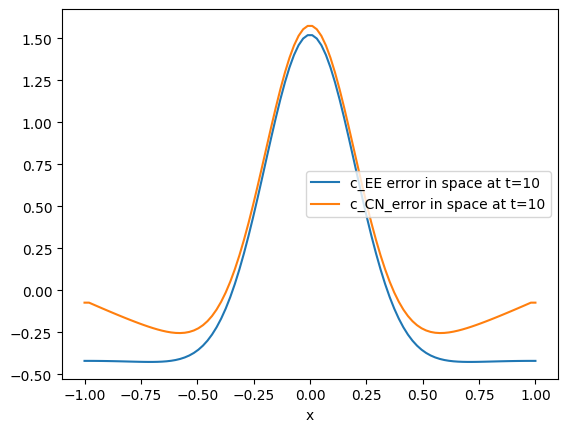

In [ ]:
# Add code to plot error here

# Define error as the residuals (difference between exact solution values and the numerically calculated values yield by each method)
# i.e. negative residual means modelled value is too high

c_EE_error = np.subtract(exact_t10, c_EE[:,-1])
c_CN_error = np.subtract(exact_t10, c_CN[:,-1])


plt.plot(x, c_EE_error, label = "c_EE error in space at t=10")
plt.plot(x, c_CN_error, label = "c_CN_error in space at t=10")
plt.xlabel('x')
plt.legend()

In [ ]:
# values of delta x are determined by the number of steps in space over the grid.
# line from function:  dx = (x[-1] - x[0]) / (len(x) - 1)


# reset original parameters except Nx (which determines delta X) and x which depends on Nx

kappa = 0.001
# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 50  # number of timesteps #SET LARGER TIMESTEPS TO EXACERBATE DIFFERENCES IN

# Size of the physical domain
x_start = -1
x_end = 1
#Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times


In [ ]:
dx_list = []
max_err_ee_list = []
max_err_cn_list = []

for i in range(50, 450, 5):
  Nx = i
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  dx = (x[-1] - x[0]) / (len(x) - 1)
  dx_list.append(dx)
  # x in a linspace array of values
  exact_t10 = (4*np.pi*kappa*20)**(-0.5)*np.exp(-x**2 / (4*kappa*20))
  c_EE = EE(x, t, kappa)[:,-1] # explicit Euler
  c_CN = CN(x, t, kappa)[:,-1] # Crank-Nicolson

  error_ee = np.subtract(exact_t10, c_EE)
  error_cn = np.subtract(exact_t10, c_CN)
  max_err_ee_list.append(max(error_ee))
  max_err_cn_list.append(max(error_cn))


Explicit Euler method took 0.40 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.20 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.24 seconds
Crank-Nicolson method took 0.11 seconds
Explicit Euler method took 0.28 seconds
Crank-Nicolson method took 0.11 seconds
Explicit Euler method took 0.27 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.47 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.30 seconds
Crank-Nicolson method took 0.15 seconds
Explicit Euler method took 0.23 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.32 seconds
Crank-Nicolson method took 0.28 seconds
Explicit Euler method took 0.52 seconds
Crank-Nicolson method took 0.23 seconds
Explicit Euler method took 0.29 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.13 seconds


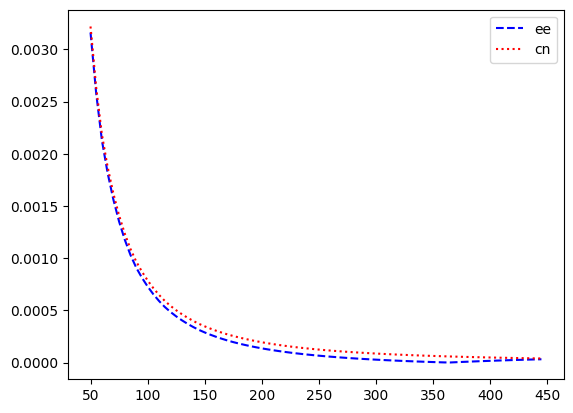

In [ ]:
plt.plot(range(50, 450, 5), max_err_ee_list, 'b--', label = "ee")
plt.plot(range(50, 450, 5), max_err_cn_list, 'r:', label = "cn")
plt.legend()

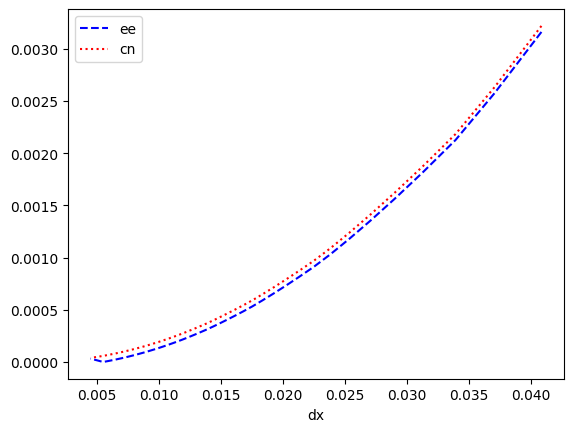

In [ ]:
plt.plot(dx_list, max_err_ee_list, 'b--', label = "ee")
plt.plot(dx_list, max_err_cn_list, 'r:', label = "cn")
plt.xlabel("dx")
plt.legend()

In [ ]:
# reset original parameters except Nx (which determines delta X) and x which depends on Nx

#kappa = 20*0.001
kappa = 0.001
# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
#Nt

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

x = np.linspace(x_start, x_end, Nx)

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.15 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.15 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.15 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.16 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.16 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.20 seconds
Explicit Euler method took 0.02 seconds


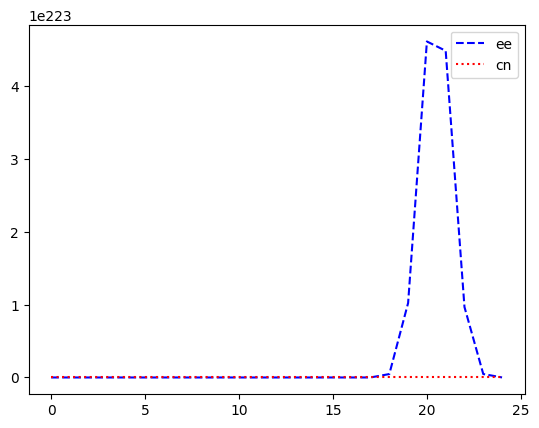

In [ ]:
dt_list = []
max_err_ee_list = []
max_err_cn_list = []

for i in range(20, 501, 20):
  Nt = i
  t = np.linspace(t_start, t_end, Nt)  # Create a vector for x
  dt = (t[-1] - t[0]) / (len(t) - 1)
  dt_list.append(dt)
  # x in a linspace array of values
  exact_t10 = (4*np.pi*kappa*20)**(-0.5)*np.exp(-x**2 / (4*kappa*20))
  c_EE = EE(x, t, kappa)[:,-1] # explicit Euler
  c_CN = CN(x, t, kappa)[:,-1] # Crank-Nicolson

  error_ee = np.subtract(exact_t10, c_EE)
  error_cn = np.subtract(exact_t10, c_CN)
  max_err_ee_list.append(max(error_ee))
  max_err_cn_list.append(max(error_cn))


plt.plot(max_err_ee_list, 'b--', label = "ee")
plt.plot(max_err_cn_list, 'r:', label = "cn")
plt.legend()

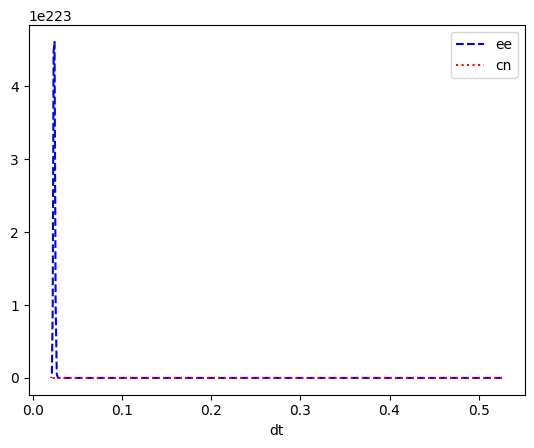

In [ ]:
plt.plot(dt_list, max_err_ee_list, 'b--', label = "ee")
plt.plot(dt_list, max_err_cn_list, 'r:', label = "cn")
plt.xlabel("dt")
plt.legend()

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

Error increases with delta_x, so when spaces in steps are larger numerical methods produce reults firther from the exact solutioni when using a residuals as a measure of error.

For Exact-Euler there was a spikein error for very small time step sizes (delta t) and erroe was very close to or equal to zero for all larger timesteps. Crank-Nicholson resulted in zero erroe or close to that for all value of delta t tried (Nt between 20 to 500 so dt between )




Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

In [ ]:
#?? coefficient matrix M

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
#Nt

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

x = np.linspace(x_start, x_end, Nx)
t = np.linspace(t_start, t_end, Nt)

#start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
M

array([[-4900.5 ,  2450.25,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [ 2450.25, -4900.5 ,  2450.25, ...,     0.  ,     0.  ,     0.  ],
       [    0.  ,  2450.25, -4900.5 , ...,     0.  ,     0.  ,     0.  ],
       ...,
       [    0.  ,     0.  ,     0.  , ..., -4900.5 ,  2450.25,     0.  ],
       [    0.  ,     0.  ,     0.  , ...,  2450.25, -4900.5 ,  2450.25],
       [    0.  ,     0.  ,     0.  , ...,     0.  ,  2450.25, -4900.5 ]])